<a href="https://colab.research.google.com/github/ekmungi/ml_examples/blob/master/pytorch_cnn_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torch torchvision

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import os, random

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader

In [4]:
composed = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.ToTensor()])

In [124]:
train_dataset = dsets.ImageFolder(root='/home/avemuri/DEV/Data/fruits/fruits-360/Training/',
                                  transform=composed)#transforms.ToTensor())

test_dataset = dsets.ImageFolder(root='/home/avemuri/DEV/Data/fruits/fruits-360/Test/',
                                 transform=transforms.ToTensor())

# train_dataset = dsets.FashionMNIST(root='./data', 
#                             train=True, 
#                             transform=transforms.ToTensor(),
#                             download=True)

# test_dataset = dsets.FashionMNIST(root='./data', 
#                            train=False, 
#                            transform=transforms.ToTensor())

In [129]:
batch_size = 1500

In [130]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [131]:
print(len(train_loader))
for image, label in train_loader:
    print(image.shape, label.shape, image[0,0,:,:].max())
    break

39
torch.Size([1500, 3, 100, 100]) torch.Size([1500]) tensor(1.)


In [132]:
class GlobalMaxPool2D(nn.Module):
    '''
    Reduce to feature space
    '''
    def __init__(self):
        super(GlobalMaxPool2D, self).__init__()
        
    def forward(self, x):
        x =  torch.max(torch.max(x, 3, keepdim=False)[0], 2, keepdim=False)[0]
        return x


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)

class CNNModel(nn.Module):
    def __init__(self, n_classes, debug=False):
        super(CNNModel, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.global_maxpool = GlobalMaxPool2D()
        self.fc1 = nn.Linear(in_features=6400, out_features=3200)
        self.fc2 = nn.Linear(in_features=3200, out_features=n_classes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dropout2d = nn.Dropout2d()
        self.dropout = nn.Dropout()
        self.flatten = Flatten()
        

        self.debug = debug
        
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        if self.debug:
            print(x.shape)
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.dropout2d(x)
        if self.debug:
            print(x.shape)
        x = self.maxpool(self.relu(self.conv3(x)))
        if self.debug:
            print(x.shape)
        
        # x = self.global_maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        if self.debug:
            print(x.shape)

        
        
        x = self.fc1(x)
        x = self.dropout(x)
        if self.debug:
            print(x.shape)
        x = self.fc2(x)
        if self.debug:
            print(x.shape)

        
        return x
            
        
        

In [133]:
model = CNNModel(n_classes, debug=True)
for image, label in train_loader:
    print(image.shape, label.shape, image[0,0,:,:].max())
    out = model(image)
    break

torch.Size([1500, 3, 100, 100]) torch.Size([1500]) tensor(1.)
torch.Size([1500, 16, 49, 49])
torch.Size([1500, 32, 23, 23])
torch.Size([1500, 64, 10, 10])
torch.Size([1500, 6400])
torch.Size([1500, 3200])
torch.Size([1500, 114])


0 : 1.8436379432678223, 55
1 : 0.957986056804657, 74
2 : 0.7492047548294067, 82
3 : 0.49386048316955566, 87
4 : 0.31379619240760803, 88
5 : 0.3648968040943146, 90
6 : 0.3499113619327545, 91
7 : 0.26558154821395874, 92
8 : 0.17882974445819855, 94
9 : 0.22727073729038239, 94
10 : 0.15220099687576294, 94
11 : 0.20971739292144775, 95
12 : 0.16799980401992798, 94
13 : 0.19289539754390717, 95
14 : 0.15649689733982086, 94
15 : 0.10594287514686584, 95
16 : 0.13384892046451569, 96
17 : 0.1364181935787201, 96
18 : 0.11715444177389145, 96
19 : 0.09165667742490768, 95
20 : 0.11768830567598343, 96
21 : 0.11120492964982986, 96
22 : 0.10614752024412155, 97
23 : 0.11963336914777756, 96
24 : 0.05850507318973541, 96
25 : 0.1112181767821312, 96
26 : 0.08454214781522751, 96
27 : 0.11409179121255875, 97
28 : 0.10627777874469757, 96
29 : 0.06590555608272552, 97


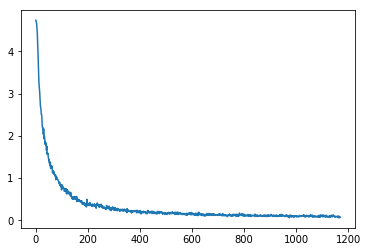

In [135]:
num_epochs = 30
learning_rate = 0.001

n_classes = 114

model = CNNModel(n_classes, debug=False)

loss_list = []

if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
    model.train()
    for iteration, (image, label) in enumerate(train_loader):


        if torch.cuda.is_available():
            X = image.cuda()
            y = label.cuda()
        else:
            X = image
            y = label

        optimizer.zero_grad()
        y_pred = model(X)
        # break
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.cpu().data)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for iteration, (image, label) in enumerate(test_loader):
            if torch.cuda.is_available():
                X = image.cuda()
                y = label.cuda()
            else:
                X = image
                y = label

            y_pred = model(X)

            _, predicted = torch.max(y_pred.data, 1)

            total += y.size(0)

            if torch.cuda.is_available():
                correct += (predicted.cpu() == y.cpu()).sum()
            else:
                correct += (predicted == y).sum()

        print("{0} : {1}, {2}".format(epoch, loss.cpu().data, np.round(100*correct/total, 2)))


plt.plot(np.arange(0,len(loss_list)), np.array(loss_list))


# Find all incorrect images

In [136]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()
with torch.no_grad():
    incorrect = np.zeros((len(test_dataset), 2))
    for count, (image, label) in enumerate(test_loader):
        if torch.cuda.is_available():
            X = image.cuda()
            y = label.cuda()
        else:
            X = image
            y = label

        y_pred = model(X)

        _, predicted = torch.max(y_pred.data, 1)

        if torch.cuda.is_available():
            incorrect[count, 0] = y.cpu().numpy()
            incorrect[count, 1] = predicted.cpu().numpy()
        else:
            incorrect[count, 0] = y.numpy()
            incorrect[count, 1] = predicted.numpy()

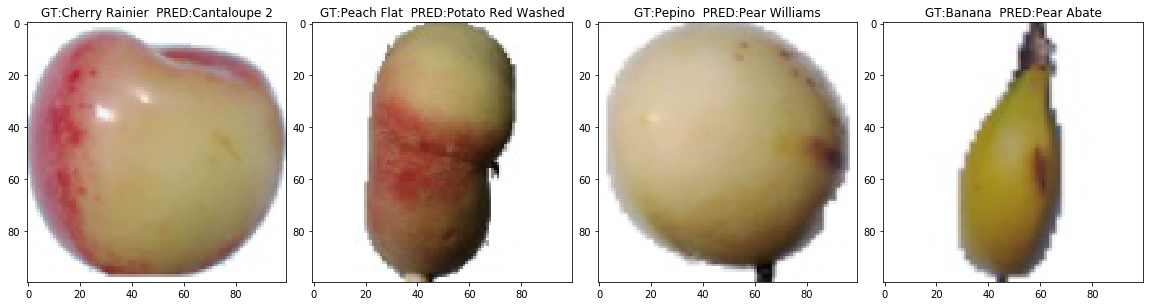

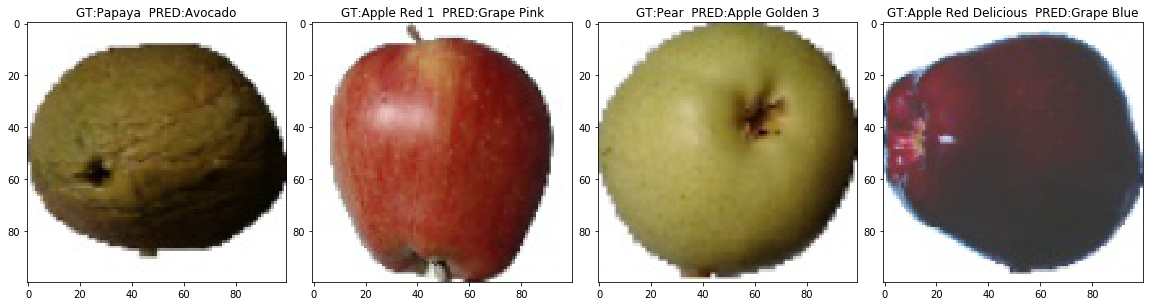

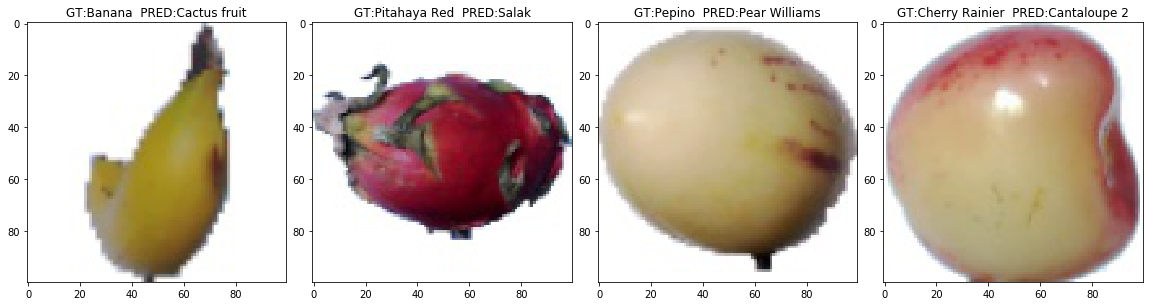

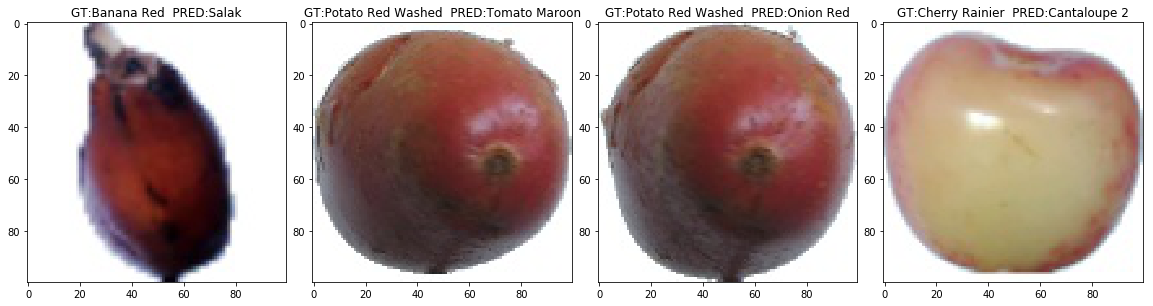

In [139]:
for _ in range(4):
    count = 4
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))#, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 1.5, wspace=.1)
    index_list = list(range(len(incorrect)))
    random.shuffle(index_list)
    for i in index_list:
        if incorrect[i,0] != incorrect[i,1]:
            image, label = test_dataset[i]
            image = np.moveaxis(image.numpy(), [0,1,2], [2,0,1])
            axs[count-1].imshow(image)
            # title = "GT:" + os.path.split(files_test[i][0])[1] + "  PRED:" + os.path.split(files_train[int(incorrect[i,1])][0])[1]
            title = "GT:" + test_dataset.classes[test_dataset.samples[i][1]] + "  PRED:" + test_dataset.classes[int(incorrect[i,1])]
            # print(title)
            axs[count-1].set_title(title)
            count -= 1

        if count == 0:
            break
    